### Define which part you are developing

- EDA for electricity dataset
- Testing ARMIA model
- Developing LinearRegression model etc.

# ARMIA Testing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [5]:
# Define the path to your CSV file
# You may have to make this path more specific to the location of your file.
csv_path = "future-gc00-daily-prices.csv"

# Read the CSV, parse 'Date' column as datetime, and set it as the index
data = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=False,
    index_col="Date"
)

# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

In [6]:
# Clean the "Close" column
data["Close"] = data["Close"].replace(',', '', regex=True)
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=["Close"], inplace=True)

/tmp/ipykernel_2198293/3431076274.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)


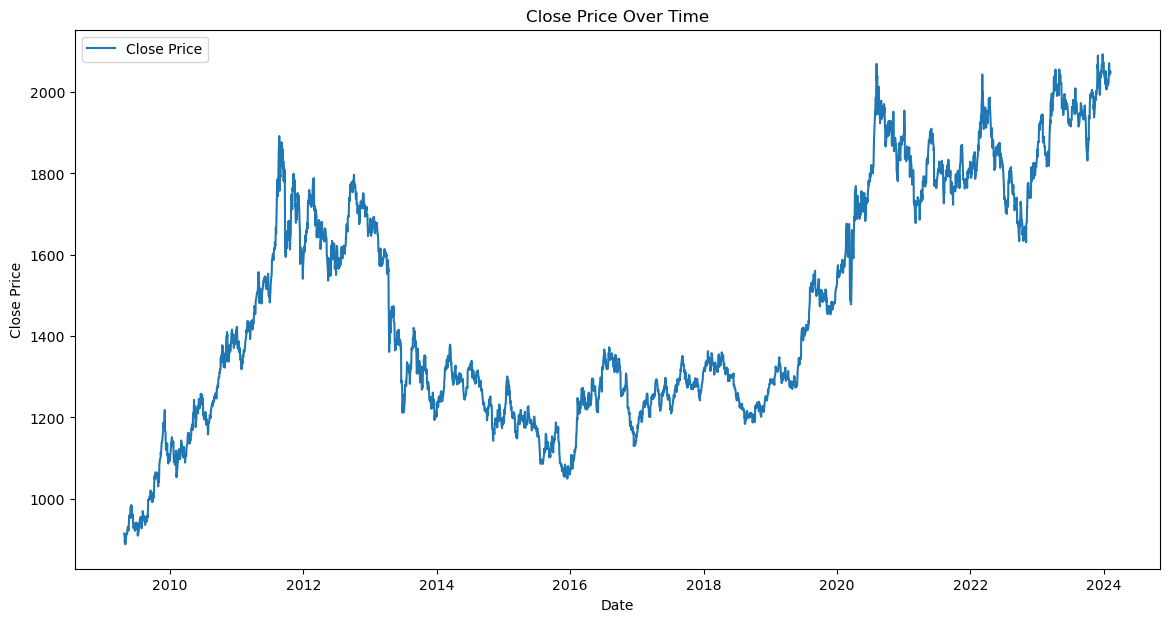

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Close"], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [8]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(data["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
data['Close_Diff'] = data['Close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(data["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -1.4367
p-value (Original): 0.5646
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -19.1308
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


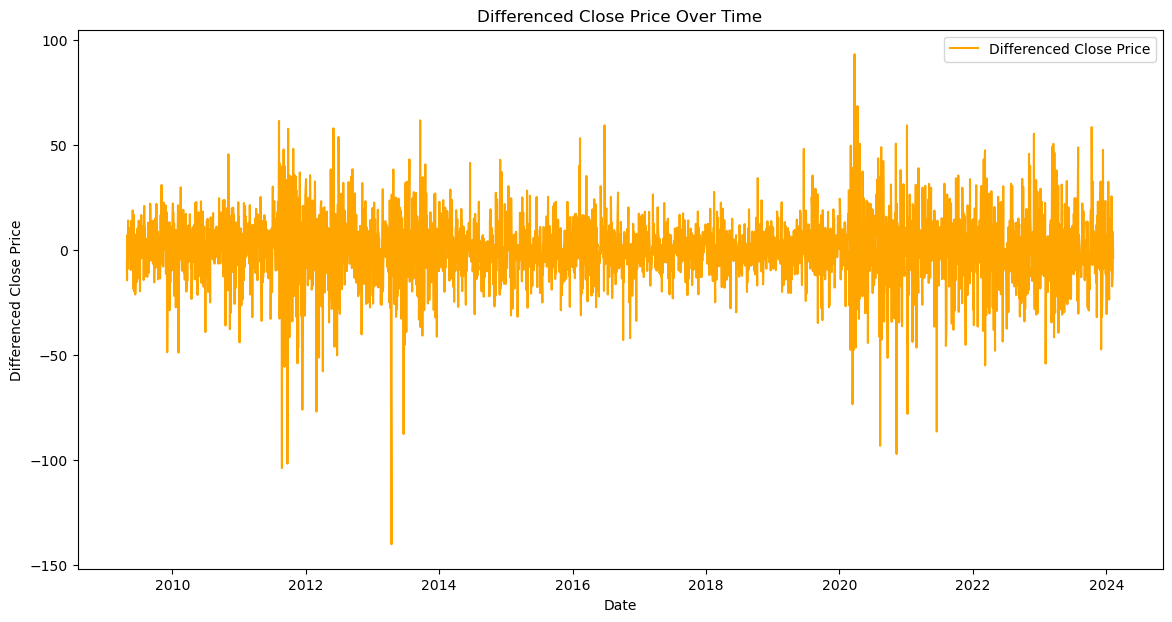

In [9]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_Diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

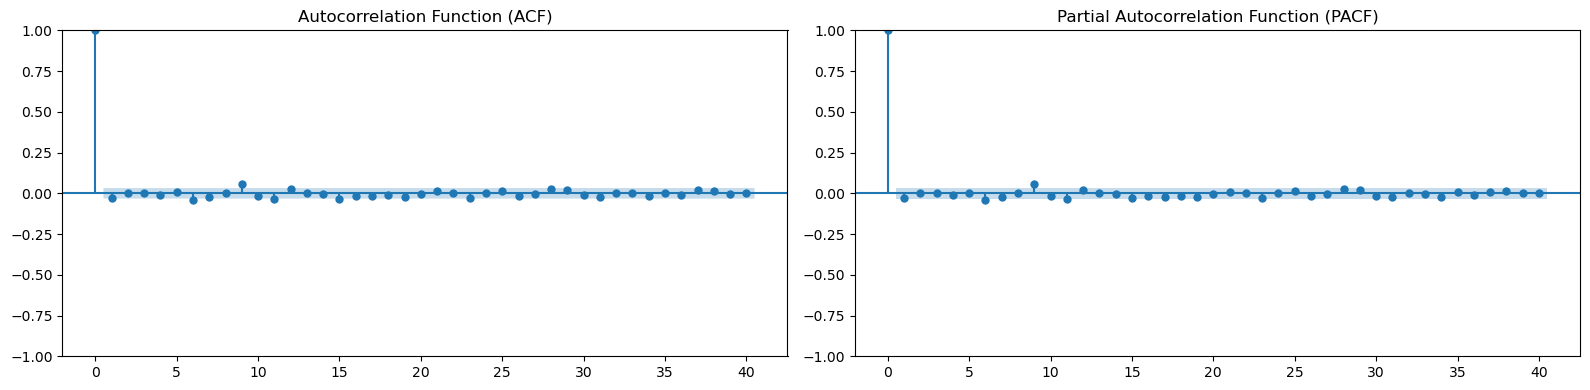

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [11]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["Close"], order=(1,1,1))
model_fit = model.fit()

/home/aic/anaconda3/envs/aic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aic/anaconda3/envs/aic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aic/anaconda3/envs/aic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/aic/anaconda3/envs/aic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/aic/anaconda3/envs/aic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


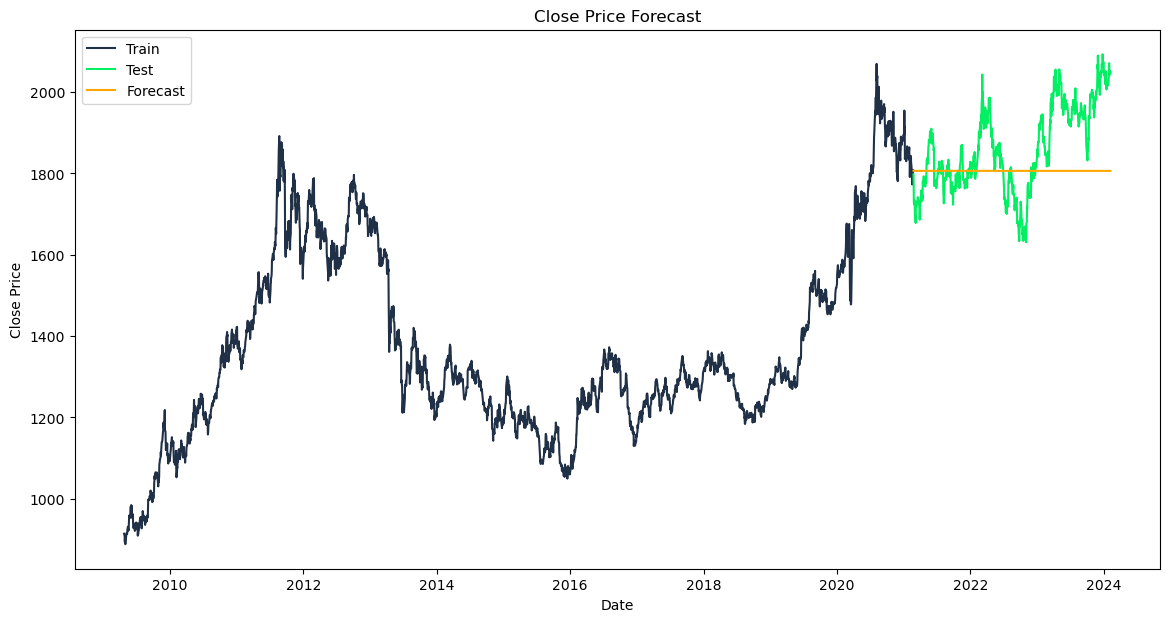

In [12]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [13]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 24602.974260658793
BIC: 24620.971282298524


In [14]:
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 118.5339


Predicting Temperature and Precipitation: ARIMA models are used in short-term and long-term weather forecasts, incorporating air-sea interactions and many other factors.